<a href="https://colab.research.google.com/github/Sushantstha2025/AI_worksheet/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set plot style
sns.set(style="whitegrid")

In [ ]:
# Load the dataset (assuming you have downloaded diabetic_data.csv from the UCI link and placed it in the working directory)
df = pd.read_csv('/content/drive/MyDrive/diabetic_data.csv')

# Replace '?' with NaN for missing values
df.replace('?', np.nan, inplace=True)

# Display basic info
print(df.info())
print(df.describe())
print(df.head())

# Check missing values
missing = df.isnull().sum() / len(df) * 100
print("Missing Values (%):")
print(missing[missing > 0])

# Assess imbalance in target
print(df['readmitted'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [ ]:
# Exploratory Data Analysis

In [ ]:
# Data Cleaning
# Drop columns with high missing (>50%) or irrelevant (identifiers)
df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# Handle missing in race and diag codes with 'Unknown'
df['race'].fillna('Unknown', inplace=True)
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col].fillna('Unknown', inplace=True)

# Binarize target: 1 if readmitted <30 days (early readmission), 0 otherwise
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop('readmitted', axis=1, inplace=True)  # Use binary target

# Summary statistics
print(df.describe())

       admission_type_id  discharge_disposition_id  admission_source_id  \
count      101766.000000             101766.000000        101766.000000   
mean            2.024006                  3.715642             5.754437   
std             1.445403                  5.280166             4.064081   
min             1.000000                  1.000000             1.000000   
25%             1.000000                  1.000000             1.000000   
50%             1.000000                  1.000000             7.000000   
75%             3.000000                  4.000000             7.000000   
max             8.000000                 28.000000            25.000000   

       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count     101766.000000       101766.000000   101766.000000    101766.000000   
mean           4.395987           43.095641        1.339730        16.021844   
std            2.985108           19.674362        1.705807         8.127566   
min 

/tmp/ipython-input-1842779162.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].fillna('Unknown', inplace=True)
/tmp/ipython-input-1842779162.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

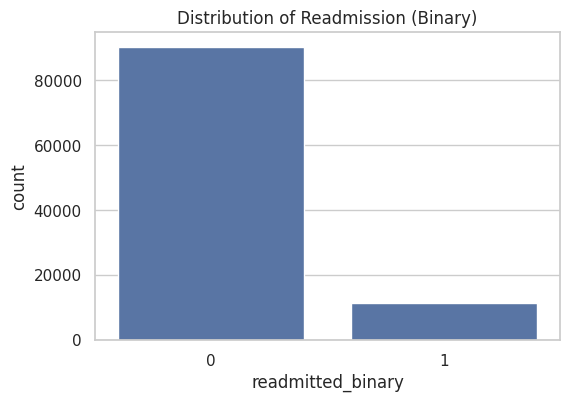

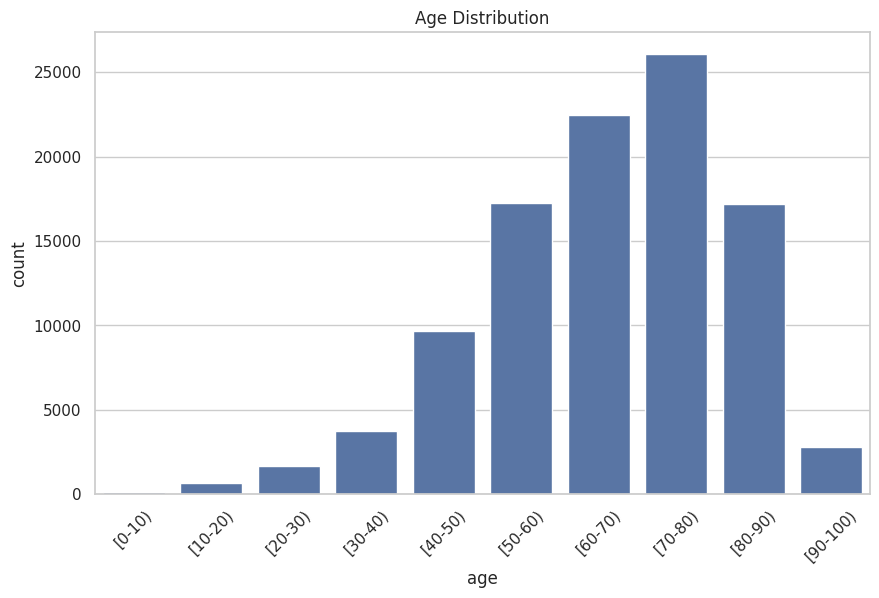

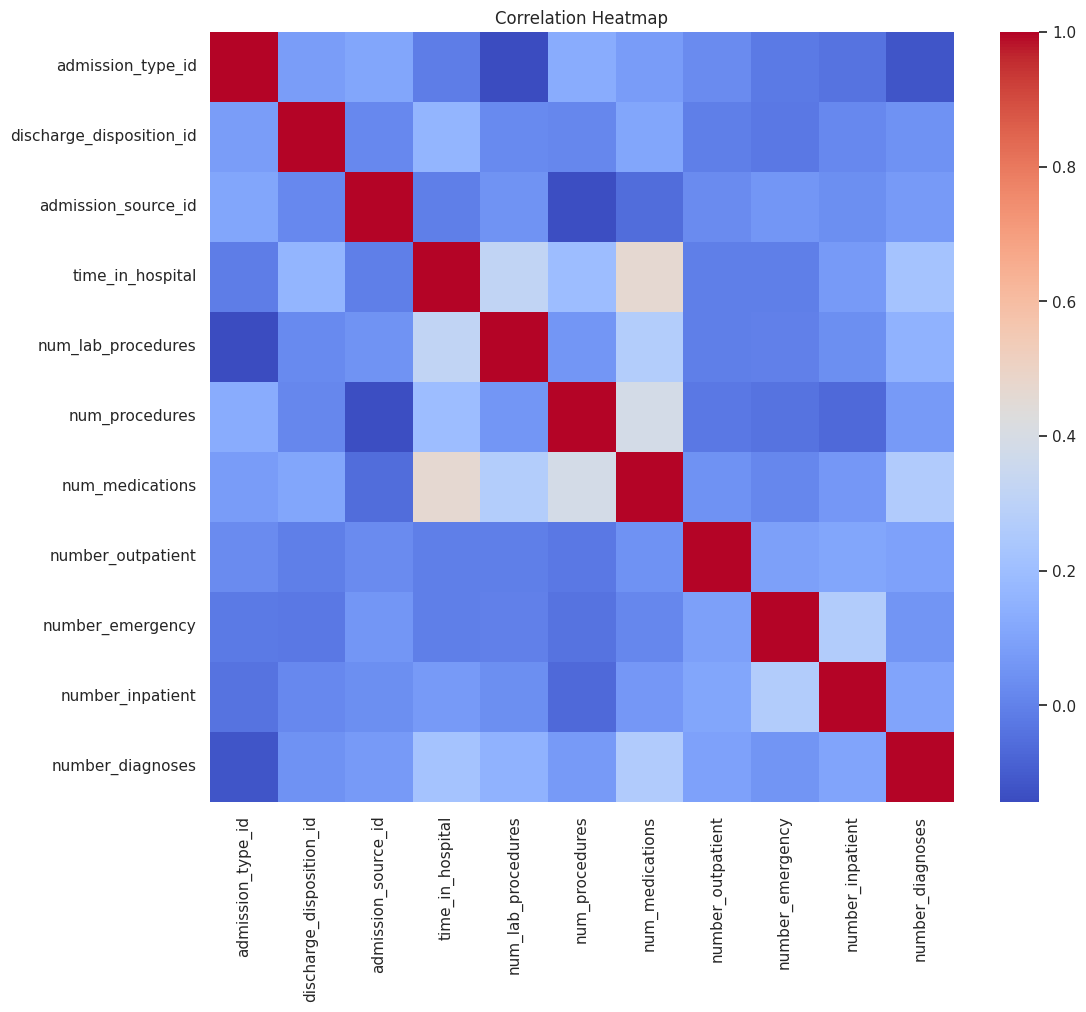

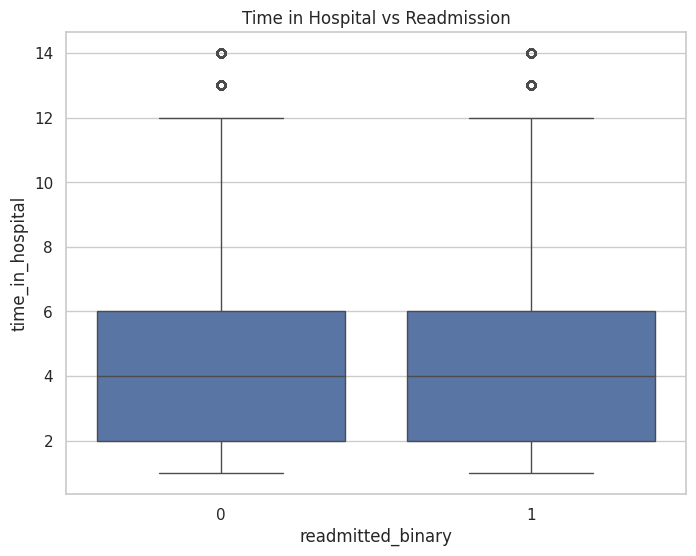

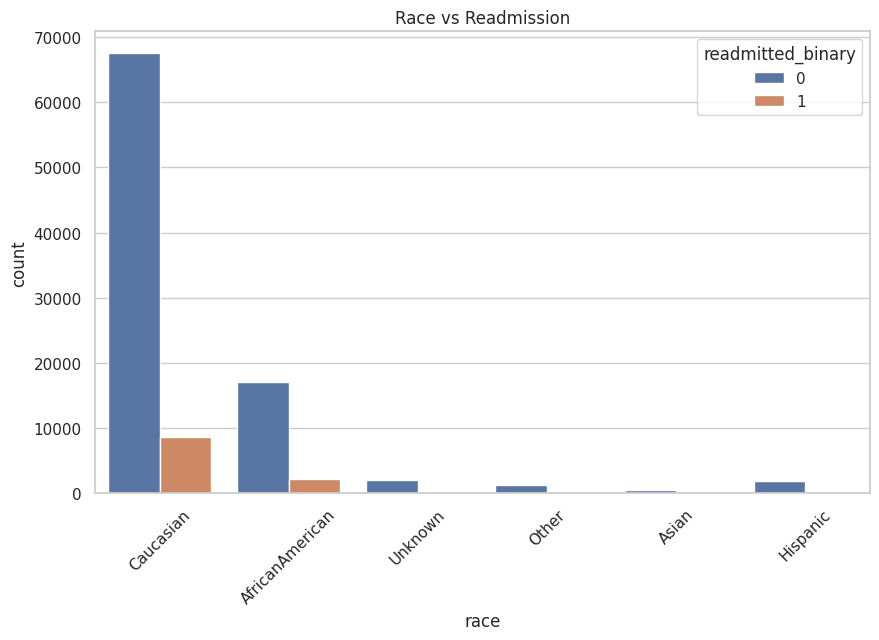

In [ ]:
# Visualizations
# Distribution of target
plt.figure(figsize=(6,4))
sns.countplot(x='readmitted_binary', data=df)
plt.title('Distribution of Readmission (Binary)')
plt.show()
print('\n')

# Age distribution
plt.figure(figsize=(10,6))
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()))
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()
print('\n')

# Correlation for numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('readmitted_binary')
corr = df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
print('\n')

# Boxplot: Time in hospital vs readmission
plt.figure(figsize=(8,6))
sns.boxplot(x='readmitted_binary', y='time_in_hospital', data=df)
plt.title('Time in Hospital vs Readmission')
plt.show()
print('\n')

# Countplot: Race vs readmission
plt.figure(figsize=(10,6))
sns.countplot(x='race', hue='readmitted_binary', data=df)
plt.title('Race vs Readmission')
plt.xticks(rotation=45)
plt.show()
print('\n')

# Insights:
# - Class imbalance: ~11% early readmissions.
# - Older patients (70-80) are more common.
# - Positive correlations between number_inpatient and readmission.
# - Longer hospital stays slightly associated with readmission.
# - Caucasian patients have higher counts, but proportions need checking for imbalance.

In [ ]:
# Neural Network Model

In [ ]:
# Preprocess data for modeling
# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns.drop(['diag_1', 'diag_2', 'diag_3'])  # Exclude diag for simplicity, or bin them if needed
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('readmitted_binary')

# For diag, simplify to first 3 chars or category (e.g., circulatory, respiratory)
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].astype(str).str[:3].where(df[col] != 'Unknown', 'Unknown')

cat_cols = list(cat_cols) + ['diag_1', 'diag_2', 'diag_3']

# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols)
    ])

# Split data
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# Build Neural Network (MLPClassifier)
# nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=200, random_state=42)
nn_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    max_iter=100,
    early_stopping=True,
    random_state=42
)


# Train
nn_model.fit(X_train_pre, y_train)

# Evaluate
y_pred_nn = nn_model.predict(X_test_pre)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Metrics
acc_nn = accuracy_score(y_test, y_pred_nn)
prec_nn = precision_score(y_test, y_pred_nn)
rec_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f"Accuracy: {acc_nn:.4f}, Precision: {prec_nn:.4f}, Recall: {rec_nn:.4f}, F1: {f1_nn:.4f}")

# Description:
# - Architecture: Two hidden layers with 100 and 50 neurons, ReLU activation.
# - Loss: Binary cross-entropy (logistic), Optimizer: Adam.

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.59      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.74      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

Accuracy: 0.8887, Precision: 0.5882, Recall: 0.0088, F1: 0.0174


In [ ]:
# Primary Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print("="*70)
print("Primary Models – Initial Run (with improvements)")
print("="*70)

# Model 1: Logistic Regression (convergence fixed + imbalance handling)
lr_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

lr_model.fit(X_train_pre, y_train)
y_pred_lr = lr_model.predict(X_test_pre)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr  = recall_score(y_test, y_pred_lr)
f1_lr   = f1_score(y_test, y_pred_lr)

# Model 2: Decision Tree (can stay simple for now)
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'     # also helps here
)

dt_model.fit(X_train_pre, y_train)
y_pred_dt = dt_model.predict(X_test_pre)

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

acc_dt  = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt  = recall_score(y_test, y_pred_dt)
f1_dt   = f1_score(y_test, y_pred_dt)

# Quick comparison print (like demo style)
print("\n" + "="*70)
print("Initial Comparison Table (Primary Models)")
print("="*70)
comparison_initial = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [acc_lr, acc_dt],
    'Precision': [prec_lr, prec_dt],
    'Recall': [rec_lr, rec_dt],
    'F1-Score': [f1_lr, f1_dt]
}).round(4)
print(comparison_initial.to_string(index=False))

Primary Models – Initial Run (with improvements)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.77     18083
           1       0.17      0.55      0.26      2271

    accuracy                           0.64     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.64      0.71     20354


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     18083
           1       0.17      0.23      0.20      2271

    accuracy                           0.79     20354
   macro avg       0.54      0.55      0.54     20354
weighted avg       0.82      0.79      0.80     20354


Initial Comparison Table (Primary Models)
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.6432     0.1668  0.5504    0.2561
      Decision Tree    0.7925     0.1726  0.2268    0.

In [ ]:
# Hyper-parameter optimization with cross validation

In [ ]:
# For Logistic Regression
from sklearn.model_selection import GridSearchCV

lr_params = {'C': [0.01, 1, 10], 'penalty': ['l2']}
lr_grid = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=42),
    lr_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
lr_grid.fit(X_train_pre, y_train)
best_lr_params = lr_grid.best_params_
best_lr_cv = lr_grid.best_score_
print(f"Best LR Params: {best_lr_params}, CV F1: {best_lr_cv:.4f}")

# For Decision Tree
dt_params = {'max_depth': [5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 4]}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_grid.fit(X_train_pre, y_train)
best_dt_params = dt_grid.best_params_
best_dt_cv = dt_grid.best_score_
print(f"Best DT Params: {best_dt_params}, CV F1: {best_dt_cv:.4f}")

Best LR Params: {'C': 10, 'penalty': 'l2'}, CV F1: 0.0427
Best DT Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}, CV F1: 0.0625


In [ ]:
# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Feature Selection for Logistic Regression
# L1-regularized Logistic Regression performs built-in feature selection
sfm_lr = SelectFromModel(
    LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=42,
        max_iter=1000
    ),
    max_features=20
)

X_train_lr = sfm_lr.fit_transform(X_train_pre, y_train)
X_test_lr = sfm_lr.transform(X_test_pre)

# Feature Selection for Decision Tree
# Trees naturally rank features by importance
sfm_dt = SelectFromModel(
    DecisionTreeClassifier(random_state=42),
    max_features=20
)

X_train_dt = sfm_dt.fit_transform(X_train_pre, y_train)
X_test_dt = sfm_dt.transform(X_test_pre)


In [ ]:
# Final Model and Comparative Analysis

In [ ]:
print(X_train_lr.shape, X_test_lr.shape)
print(X_train_dt.shape, X_test_dt.shape)

# Rebuild LR with best params and selected features
final_lr = LogisticRegression(**best_lr_params, solver='liblinear', class_weight='balanced', random_state=42)
final_lr.fit(X_train_lr, y_train)
y_pred_final_lr = final_lr.predict(X_test_lr)

acc_final_lr = accuracy_score(y_test, y_pred_final_lr)
prec_final_lr = precision_score(y_test, y_pred_final_lr)
rec_final_lr = recall_score(y_test, y_pred_final_lr)
f1_final_lr = f1_score(y_test, y_pred_final_lr)

# Rebuild DT
final_dt = DecisionTreeClassifier(**best_dt_params, class_weight='balanced', random_state=42)
final_dt.fit(X_train_dt, y_train)
y_pred_final_dt = final_dt.predict(X_test_dt)

acc_final_dt = accuracy_score(y_test, y_pred_final_dt)
prec_final_dt = precision_score(y_test, y_pred_final_dt)
rec_final_dt = recall_score(y_test, y_pred_final_dt)
f1_final_dt = f1_score(y_test, y_pred_final_dt)

# Comparison Table
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Features': [20, 20],
    'CV Score (F1)': [best_lr_cv, best_dt_cv],
    'Accuracy': [acc_final_lr, acc_final_dt],
    'Precision': [prec_final_lr, prec_final_dt],
    'Recall': [rec_final_lr, rec_final_dt],
    'F1-Score': [f1_final_lr, f1_final_dt]
})
print(comparison)

(81412, 20) (20354, 20)
(81412, 20) (20354, 20)
                 Model  Features  CV Score (F1)  Accuracy  Precision  \
0  Logistic Regression        20       0.042678  0.887049   0.333333   
1        Decision Tree        20       0.062476  0.651764   0.173158   

     Recall  F1-Score  
0  0.012329  0.023779  
1  0.561867  0.264730  
